# SABR Implied Volatility
------------------
> **Idriss Afra**

This project aims to construct the Implied Volatility surface under the SABR model.

## SABR Volatility model

SABR is a dynamic model in which both the forward and the volatility are represented by stochastic state variables whose time evolution is given by the following system of stochastic differential equations :

$$
\begin{align}
dF_t & = \sigma_t F_t^\beta dW_t^1\\
\frac{d\sigma_t}{\sigma_t} & = \alpha dW_t^2\\
d<W^1,W^2>_t & = \rho dt
\end{align}
$$

Where :
* $F_0$ is the forward rate at $t = 0$
* $\sigma_0$ is the initial value of the volatility
* $\alpha$ is the volatility of the volatility
* $\beta$ is the forward exponent
* $\rho$ is the correlation between the forward and the volatility
* $W^1$ and $W^2$ are two standard brownien motions

<br>Under the SABR model, the prices of European call options are given by the Black's formula. In fact, for a current forward rate $F$, strike $K$, and implied volatility $\sigma_{SABR}(K, F)$, the price of an European call option with maturity T is :

$$
\begin{align}
C_{BLACK}(F_0, K, \sigma_{SABR}(K,F_0), T) & = e^{-rT} \left[ F_0 × N(d_1) - K × N(d_2) \right] \\
d_{1} & = \frac{ln\left(\frac{F_0}{K}\right) + \frac{1}{2} \sigma_{SABR}(K,F_0)^2 T}{\sigma_{SABR}(K,F_0) \sqrt{T}} \\
d_{2} & = d_{1} - \sigma_{SABR}(K,F_0) \sqrt{T}
\end{align}
$$

<br> Where $\sigma_{SABR}(K,F_0)$ follows the Hagan's formula (*2002 SABR Log-Normal Volatility expansion*) :

$$
\begin{align}
\sigma_{SABR}(K,F_0) & = \frac{\sigma_0 × \left[ 1 + \left( \frac{(1-\beta)^2}{24} × \frac{\sigma_0^2}{(F_0.K)^{1-\beta}} + \frac{1}{4} × \frac{\rho .\beta .\alpha .\sigma_0}{(F_0.K)^{(1-\beta)/2}} +\frac{\alpha^2 (2-3\rho^2)}{24} \right) × T \right]}{(F_0.K)^{(1-\beta)/2} × \left[1 + \frac{(1-\beta)^2}{24} ln^2\left(\frac{F_0}{K}\right) +  \frac{(1-\beta)^4}{1920} ln^4\left(\frac{F_0}{K}\right)\right]} × \frac{z}{\chi{(z)}} \\
z & = \frac{\alpha}{\sigma_0} × (F_0.K)^{(1-\beta)/2} × ln\left(\frac{F_0}{K}\right) \\
\chi{(z)} & = ln\left(\frac{\sqrt{1-2\rho z + z^2} + z - \rho}{1-\rho}\right)
\end{align}
$$
<br>This model can be used to fit the implied volatility surface.

In [1]:
import numpy as np

def sabr_vol(T, K, F0, sigma0, alpha, rho, beta=0.5) :
  """
  Hagan's 2002 SABR log-normal vol expansion.
  The strike K can be a scalar or an array, the function will return an array
  of log-normal vols.
  """
  eps = 1e-04
  fk_beta = (F0 * K)**(1 - beta)
  log_fk = np.log(F0/K)

  a = ((1 - beta)**2 / 24) * (sigma0**2 / fk_beta)
  b = 0.25 * rho * beta * alpha * sigma0 / fk_beta**0.5
  c = (2 - 3 * rho**2) * alpha**2 / 24
  d = fk_beta**0.5
  e = (1 - beta)**2 * log_fk**2 / 24
  f = (1 - beta)**4 * log_fk**4 / 1920
  z = alpha * fk_beta**0.5 * log_fk / sigma0

  # For close points to ATM, z and x(z) become close to zero and should be removed for the Hagan's formula
  num = sigma0 * (1 + (a + b + c) * T)
  num = np.where(abs(z) > eps, num * z, num)
  den = d * (1 + e + f)
  den = np.where(abs(z) > eps, den * x(rho, z), den)

  return num / den

def x(rho, z) :
  """
  Return function x used in Hagan's 2002 SABR log-normal vol expansion.
  """
  num = (1 - 2 * rho * z + z**2)**0.5 + z - rho
  den = 1 - rho
  return  np.log (num / den)


##SABR Calibration

In order to use the SABR model, we need to first calibrate its parameters : $\sigma_0$, $\alpha$, $\beta$, and $\rho$.

These parameters impact the SABR volatility curves as follows :
* $\sigma_0$ controls the initial level of the curve
* $\alpha$ controls the convexity of the curve
* $\rho$ and $\beta$ control the curvature of the curve

<br>$\beta$ can be estimated by linear regression on a time series of logs of ATM market volatilities and logs of forward rates.

In fact :
$$
\sigma_{SABR}^{ATM}  = \sigma_{SABR}(K = F_0, F_0) ≈ \frac{\sigma_0}{F_0^{1-\beta}}
$$
And so :
$$
ln(\sigma_{SABR}^{ATM})  ≈ ln(\sigma_0) - (1-\beta) × ln(F_0)
$$
<br> In practice, $\beta$ is set manually. In our case : $0.5$.

As for the remaining parameters, we will need to go through a minimization process to replicate the market implied volatilities.

For each market tenor $T$ :
$$
(\sigma_0^T, \alpha^T, \rho^T) = ArgMin_{(\sigma_0, \alpha, \rho)} ∑_{K_i ∈ Market}\left(\sigma_{SABR}(K,F_0, \sigma_0, \alpha, \rho) - \sigma_{K_i, T}^{Market}\right)^2
$$



In [2]:
from scipy.optimize import minimize

def sabr_calibration_1(T, F0, strikes, vol_market, beta = 0.5) :
  """
  1st calibration method.
  SABR model calibration : Sigma0, Alpha, and Rho.
  """
  parameters0 = np.array([vol_market[len(vol_market) // 2], 0.2, -0.2]) # vol_market[len(vol_market) // 2] is the closest point vol to ATM, 0.2 and -0.2 were chosen arbitrary
  res = minimize(obj_func_1, x0=parameters0, args=(T, F0, strikes, vol_market, beta), bounds=((0.01, None), (0.01, None), (-0.99, 0.99)))
  return res.x

def obj_func_1(parameters, T, F0, strikes, vol_market, beta) :
  """
  The Sum Squared Error function : Used as the objective function in the SABR Calibration.
  """
  sabr_volatilities = sabr_vol(T, strikes, F0, parameters[0], parameters[1], parameters[2], beta)
  sse = 0
  for i in range(len(strikes)) :
    sse += (sabr_volatilities[i] - vol_market[i])**2
  return sse


Calibrated parameters :  {'Sigma0': 0.06619432925209454, 'Alpha': 0.8202140728403683, 'Rho': 0.23292913561727263}


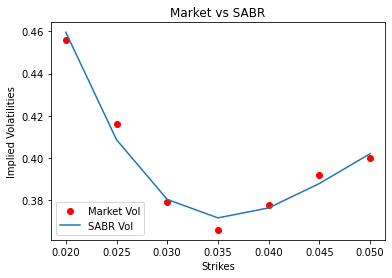

In [3]:
#Test SABR Calibration : 1st Method.

import math
import matplotlib.pyplot as plt

T = 1
S0 = 3.5 / 100
r = 2 / 100
discount = math.exp(-r * T)
F0 = S0 / discount

strikes  = np.array([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]) / 100
vol_market = np.array([45.6, 41.6, 37.9, 36.6, 37.8, 39.2, 40.0]) / 100

params = sabr_calibration_1(T, F0, strikes, vol_market)
print("Calibrated parameters : ", {"Sigma0" : params[0], "Alpha" : params[1], "Rho" : params[2]})

plt.ylabel("Implied Volatilities")
plt.xlabel("Strikes")
plt.title("Market vs SABR")
plt.scatter(strikes, vol_market, color="red", label="Market Vol")
vol_sabr = sabr_vol(T, strikes, F0, params[0], params[1], params[2])
plt.plot(strikes, vol_sabr, label="SABR Vol")
plt.legend(loc="lower left")
plt.show()

A more sophisticated method is to calibrate $\alpha$ and $\rho$ by implying $\sigma_0$ from the ATM market volatility.

In fact :

$$
\sigma_{SABR}^{ATM}(K = F_0, F_0) = \frac{\sigma_0 × \left[1 + \left(\frac{(1-\beta)^2}{24} × \frac{\sigma_0^2}{F_0^{2-2\beta}} + \frac{1}{4} × \frac{\rho .\beta .\alpha .\sigma_0}{F_0^{2-2\beta}} +\frac{\alpha^2 (2-3\rho^2)}{24}\right) × T\right]}{F_0^{1-\beta}}
$$

And so :

$$
\frac{(1-\beta)^2.T}{24.F_0^{2-2\beta}} × \sigma_0^3 + \frac{1}{4} × \frac{\rho .\beta .\alpha.T}{F_0^{2-2\beta}} × \sigma_0^2 + \left[1 + \frac{\alpha^2 (2-3\rho^2)T}{24}\right] × \sigma_0 - \sigma^{ATM} F_0^{1-\beta} = 0
$$

Therefore : $\sigma_0(\alpha, \rho) $ is a real positive root of the above equation. In practice, we take the the smallest real positive root.

For this calibration method, the minimization process changes to :

$$
(\sigma_0^T, \alpha^T, \rho^T) = ArgMin_{\left(\alpha, \rho\right)} ∑_{K_i ∈ Market}\left(\sigma_{SABR}(K,F_0, \sigma_0(\alpha, \rho), \alpha, \rho) - \sigma_{K_i, T}^{Market}\right)^2
$$

Since $\sigma_0$ calibration depends strongly on the ATM volatility quote, this second method fit the ATM market volatilities better.

In [4]:
from scipy.optimize import minimize

def sabr_calibration_2(T, F0, strikes, vol_market, beta = 0.5) :
  """
  2nd calibration method.
  SABR model calibration : Sigma0, Alpha, and Rho.
  """
  parameters0 = np.array([0.2, -0.2]) # Alpha, Rho : Chosen arbitrary
  res = minimize(obj_func_2, x0=parameters0, args=(T, F0, strikes, vol_market, beta), bounds=((0.01, None), (-0.99, 0.99)))
  return [sigma0_implied(res.x, T, F0, strikes, vol_market)] + list(res.x)

def obj_func_2(parameters, T, F0, strikes, vol_market, beta = 0.5) :
  """
  The Sum Squared Error function : Used as the objective function in the SABR Calibration.
  """
  sigma0 = sigma0_implied(parameters, T, F0, strikes, vol_market, beta)
  sabr_volatilities = sabr_vol(T, strikes, F0, sigma0, parameters[0], parameters[1], beta)
  sse = 0
  for i in range(len(strikes)) :
    sse += (sabr_volatilities[i] - vol_market[i])**2
  return sse

def sigma0_implied(parameters, T, F0, strikes, vol_market, beta = 0.5) :
  """
  This function computes the smallest real positive root of the above cubic equation.
  """
  moneyness = strikes / F0
  moneyness -= 1
  # Search for the closest point to ATM
  atm_index = np.where(moneyness == min(abs(moneyness)))[0][0] if min(abs(moneyness)) in moneyness else np.where(moneyness == -min(abs(moneyness)))[0][0]
  atm_vol = vol_market[atm_index]

  f0_beta = F0**(2*(1 - beta))
  alpha = parameters[0]
  rho = parameters[1]
  a = ((1-beta)**2 * T) / (24 * f0_beta)
  b = 0.25 * rho * beta * alpha * T / f0_beta**0.5
  c = 1 + alpha**2 * T * (2 - 3 * rho**2) / 24
  d = - atm_vol * f0_beta**0.5

  sigma0_roots = []
  for s0 in np.roots([a, b, c, d]) :
    if s0.imag == 0 and s0 > 0 :
      sigma0_roots += [s0.real]

  return min(sigma0_roots) if len(sigma0_roots) > 0 else sys.exit("The algorithm failed to converge. Please review the input data.")

Calibrated parameters :  {'Sigma0': 0.06408171488206026, 'Alpha': 0.8738250023510165, 'Rho': 0.20214657234612063}


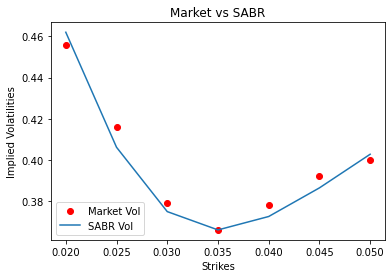

In [5]:
#Test SABR Calibration : 2nd Method.

import math
import matplotlib.pyplot as plt

T = 1
S0 = 3.5 / 100
r = 0
discount = math.exp(-r * T)
F0 = S0 / discount

strikes  = np.array([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]) / 100
vol_market = np.array([45.6, 41.6, 37.9, 36.6, 37.8, 39.2, 40.0]) / 100

params = sabr_calibration_2(T, F0, strikes, vol_market)
print("Calibrated parameters : ", {"Sigma0" : params[0], "Alpha" : params[1], "Rho" : params[2]})

plt.ylabel("Implied Volatilities")
plt.xlabel("Strikes")
plt.title("Market vs SABR")
plt.scatter(strikes, vol_market, color="red", label="Market Vol")
vol_sabr = sabr_vol(T, strikes, F0, params[0], params[1], params[2])
plt.plot(strikes, vol_sabr, label="SABR Vol")
plt.legend(loc="lower left")
plt.show()

##Application : Equity Options Market

The Equity listed options are quoted in prices and not in volatilities. Therefore, market volatilities need to be implied before applying the SABR fitting method.

To do so, we use the Newton-Raphson algorithm to find the root $\sigma_{Imp}(K_{market}, T_{market})$ of the following equation :

$$
BS(F_0, K, \sigma_{Imp}(K_{market},T_{market}), T) - MarketPrice(K_{market}, T_{market}) = 0
$$



In [6]:
from scipy.stats import norm

def black_scholes(flavor, K, T, S, r, vol, q=0) :
  """
  The Black-Scholes price.
  """
  v2T = vol**2 * T
  d1 = (np.log(S/K) + (r - q) * T + v2T / 2) / v2T**0.5
  d2 = d1 - v2T**0.5
  phi = 1 if flavor.upper() == "CALL" else  -1
  return phi * (S * math.exp(-q * T) * norm.cdf(phi * d1) - K * math.exp(-r * T) * norm.cdf(phi * d2))

def vega_bs(K, T, S, r, vol, q=0) :
  """
  The Black-Scholes Vega greek : The derivative of the option value with respect to the volatility of the underlying asset.
  """
  v2T = vol**2 * T
  d2 = (math.log(S/K) + (r - q) * T - v2T / 2) / v2T**0.5
  return K * math.exp(-r * T) * norm.pdf(d2) * T**0.5

In [7]:
import sys

def newton_raphson(market_price, init_vol, flavor, K, T, S, r, q=0):
  """
  The Newton-Raphson algorithm : Implied volatilities from market prices
  """
  eps = 1e-07
  vol = init_vol
  func = black_scholes(flavor, K, T, S, r, vol, q) - market_price
  func_deriv = vega_bs(K, T, S, r, vol, q)
  error = sys.exit("The algorithm failed to converge. Please review the input data.") if func_deriv < 0.0001 else "No error."
  next_vol = vol - func / func_deriv
  error = sys.exit("The algorithm failed to converge. Please review the input data.") if next_vol < 0.0001 else "No error."
  nb_iteration = 1
  while abs(next_vol - vol) > eps :
    vol = next_vol
    func = black_scholes(flavor, K, T, S, r, vol, q) - market_price
    func_deriv = vega_bs(K, T, S, r, vol, q)
    error = sys.exit("The algorithm failed to converge. Please review the input data.") if func_deriv < 0.0001 else "No error."
    next_vol = vol - func / func_deriv
    error = sys.exit("The algorithm failed to converge. Please review the input data.") if next_vol < 0.0001 else "No error."
    nb_iteration += 1
    error = sys.exit("The algorithm failed to converge. Please review the input data.") if nb_iteration > 300 else "No error."

  return next_vol

In [8]:
# Test the Newton-Raphon algorithm

from decimal import Decimal

T = 1
S0 = 100
r = 0.015
discount = math.exp(-r * T)
F0 = S0 / discount
market_prices = np.array([0.1, 0.12, 0.14, 0.16, 0.13, 0.11, 0.08])
flavors = np.array(["Put", "Put", "Put", "Put", "Call", "Call", "Call"]) #The Fourth Option is the ATM
strikes = np.array([F0 - 3, F0 - 2, F0 - 1,   F0, F0 + 1, F0 + 2, F0 + 3])

implied_vols = []
for i in range(len(market_prices)) :
  implied_vol = newton_raphson(market_prices[i], 0.1, flavors[i], strikes[i], T, S0, r)
  implied_vols += [implied_vol]
  bs_price = black_scholes(flavors[i], strikes[i], T, S0, r, implied_vol)
  print("Error between Market price and BS(Implied Volatility) for the strike " + str(round(strikes[i], 2)) + " : ",'%.2E' % Decimal(abs(market_prices[i] - bs_price)))


Error between Market price and BS(Implied Volatility) for the strike 98.51 :  6.74E-15
Error between Market price and BS(Implied Volatility) for the strike 99.51 :  6.32E-14
Error between Market price and BS(Implied Volatility) for the strike 100.51 :  4.11E-15
Error between Market price and BS(Implied Volatility) for the strike 101.51 :  3.41E-15
Error between Market price and BS(Implied Volatility) for the strike 102.51 :  6.11E-15
Error between Market price and BS(Implied Volatility) for the strike 103.51 :  2.43E-13
Error between Market price and BS(Implied Volatility) for the strike 104.51 :  1.71E-15


Let's now take a close look at options on AAPL (Apple Inc. Stock). Let's consider AAPL 3W and 1M European options :

Calibrated parameters :  {'Sigma0': 2.6630368305753325, 'Alpha': 2.4142520695649656, 'Rho': -0.5413598339681385}


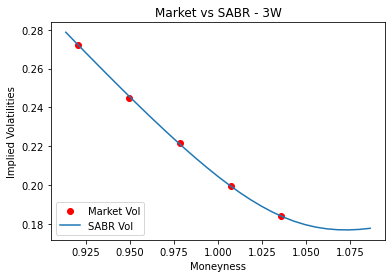

In [9]:
from datetime import date

now_date = date(2023, 5, 8)
# Spot price
S0 = 173.5
# ZC rate
r = 5.17 / 100

# ******  First Tenor Data ************************
tenor1 = date(2023, 5, 26)
# Dividend yield
d1 = 2.25 / 100
strikes1 = np.array([160, 165, 170, 175, 180])
prices1 = np.array([0.4, 0.84, 1.82, 2.49, 0.77]) # OTM listed calls and puts prices
flavors1 = np.array(["Put"] * 3 + ["Call"] * 2)
T1 = (tenor1 - now_date).days / 365
discount = math.exp(-r * T1)
# Fwd price
F0 = S0 * math.exp(-d1 * T1) / discount
# *************************************************

# Implied Volatilities using the Newton-Raphson Algorithm
implied_vols1 = []
for i in range(len(strikes1)):
    implied_vols1 += [newton_raphson(prices1[i], 0.2, flavors1[i], strikes1[i], T1, S0, r, d1)]

# SABR calibration (1st method)
sabr_params1 = sabr_calibration_1(T1, F0, strikes1, implied_vols1)
print("Calibrated parameters : ", {"Sigma0" : sabr_params1[0], "Alpha" : sabr_params1[1], "Rho" : sabr_params1[2]})
vol_sabr1 = sabr_vol(T1, strikes1, F0, sabr_params1[0], sabr_params1[1], sabr_params1[2])

# Volatility Skews : Market vs SABR
plt.ylabel("Implied Volatilities")
plt.xlabel("Moneyness")
plt.title("Market vs SABR - 3W")

plt.scatter(strikes1 / F0, implied_vols1, color="red", label="Market Vol")

x_axis = np.linspace(F0 - 15, F0 + 15, 29)
vol_sabr_smooth1 = sabr_vol(T1, x_axis, F0, sabr_params1[0], sabr_params1[1], sabr_params1[2])
plt.plot(x_axis / F0, vol_sabr_smooth1, label="SABR Vol")
plt.legend(loc="lower left")
plt.show()

Calibrated parameters :  {'Sigma0': 2.6693316299906624, 'Alpha': 1.8946821764455142, 'Rho': -0.6730123766885806}


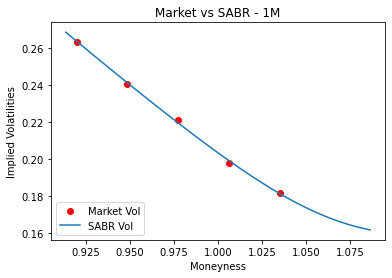

In [10]:
from datetime import date

# ******  Second Tenor Data ***********************
tenor2 = date(2023, 6, 2)
# Dividend Yield
d2 = 1.62 / 100
strikes2 = np.array([160, 165, 170, 175, 180])
prices2 = np.array([0.63, 1.2, 2.3, 3.08, 1.15]) # OTM listed calls and puts prices
flavors2 = np.array(["Put"] * 3 + ["Call"] * 2)
T2 = (tenor2 - now_date).days / 365
discount = math.exp(-r * T2)
# Fwd price
F0 = S0 * math.exp(-d2 * T2) / discount
# *************************************************

# Implied Volatilities using the Newton-Raphson Algorithm
implied_vols2 = []
for i in range(len(strikes2)):
  implied_vols2 += [newton_raphson(prices2[i], 0.2, flavors2[i], strikes2[i], T2, S0, r, d2)]

# SABR calibration (1st method)
sabr_params2 = sabr_calibration_1(T2, F0, strikes2, implied_vols2)
print("Calibrated parameters : ", {"Sigma0" : sabr_params2[0], "Alpha" : sabr_params2[1], "Rho" : sabr_params2[2]})
vol_sabr2 = sabr_vol(T2, strikes2, F0, sabr_params2[0], sabr_params2[1], sabr_params2[2])

# Volatility Skews : Market vs SABR
plt.ylabel("Implied Volatilities")
plt.xlabel("Moneyness")
plt.title("Market vs SABR - 1M")

plt.scatter(strikes2 / F0, implied_vols2, color="red", label="Market Vol")

x_axis = np.linspace(F0 - 15, F0 + 15, 29)
vol_sabr_smooth2 = sabr_vol(T2, x_axis, F0, sabr_params2[0], sabr_params2[1], sabr_params2[2])
plt.plot(x_axis / F0, vol_sabr_smooth2, label="SABR Vol")
plt.legend(loc="lower left")
plt.show()

In order to implcite volatilities for non-quoted maturities, we can interpolate SABR parameters and construct smiles using these latter :

In [11]:
from scipy.interpolate import interp1d

maturities = [T1, T2]
sigma0 = [sabr_params1[0], sabr_params2[0]]
alpha = [sabr_params1[1], sabr_params2[1]]
rho = [sabr_params1[2], sabr_params2[2]]

# Linear Interpolation of the SABR parameters
sigma0_interp = interp1d(maturities, sigma0, kind='linear', fill_value="extrapolate")
alpha_interp = interp1d(maturities, alpha, kind='linear', fill_value="extrapolate")
rho_interp = interp1d(maturities, rho, kind='linear', fill_value="extrapolate")

# Let's choose a middle maturity between T1 and T2 and interpolate linearly the SABR parameters
T_NonQuoted = (T1 + T2) / 2
sabr_params_NonQuoted = [sigma0_interp(T_NonQuoted), alpha_interp(T_NonQuoted), rho_interp(T_NonQuoted)]

In [12]:
# SABR Volatility Skews : T1, T_NonQuoted, T2
moneyness = np.linspace(0.9, 1.05, 16)
maturities = np.array([T1, T_NonQuoted, T2])
forwards = S0 * np.array([math.exp((r - d1) * T1), math.exp((r - (d1 + d2) / 2 ) * T_NonQuoted), math.exp((r - d2) * T2)]) # The dividend yield up to T_NonQuoted is approached by (d1 + d2) / 2

vol_sabr1 = sabr_vol(T1, forwards[0] * moneyness, forwards[0], sabr_params1[0], sabr_params1[1], sabr_params1[2])
vol_sabr = sabr_vol(T_NonQuoted, forwards[1] * moneyness, forwards[1], sabr_params_NonQuoted[0], sabr_params_NonQuoted[1], sabr_params_NonQuoted[2])
vol_sabr2 = sabr_vol(T2, forwards[2] * moneyness, forwards[2], sabr_params2[0], sabr_params2[1], sabr_params2[2])


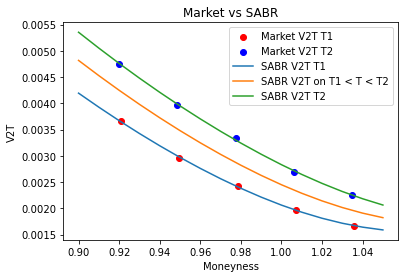

In [13]:
# Volatility Skews : Market vs SABR
plt.ylabel("V2T")
plt.xlabel("Moneyness")
plt.title("Market vs SABR")

plt.scatter(strikes1 / forwards[0], np.array(implied_vols1)**2 * T1, color="red", label="Market V2T T1")
plt.scatter(strikes2 / forwards[2], np.array(implied_vols2)**2 * T2, color="blue", label="Market V2T T2")

plt.plot(moneyness, vol_sabr1**2 * T1, label="SABR V2T T1")
plt.plot(moneyness, vol_sabr**2 * T_NonQuoted, label="SABR V2T on T1 < T < T2")
plt.plot(moneyness, vol_sabr2**2 * T2, label="SABR V2T T2")

plt.legend(loc="upper right")
plt.show()